

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/753) /content/burger-trim.mp4: 384x640 1 hamburguer, 9.5ms
video 1/1 (frame 2/753) /content/burger-trim.mp4: 384x640 1 hamburguer, 6.2ms
video 1/1 (frame 3/753) /content/burger-trim.mp4: 384x640 (no detections), 7.5ms
video 1/1 (frame 4/753) /content/burger-trim.mp4: 384x640 (no detections), 6.1ms
video 1/1 (frame 5/753) /content/burger-trim.mp4: 384x640 1 hamburguer, 10.0ms
video 1/1 (frame 6/753) /content/burger-trim.mp4: 384x640 1

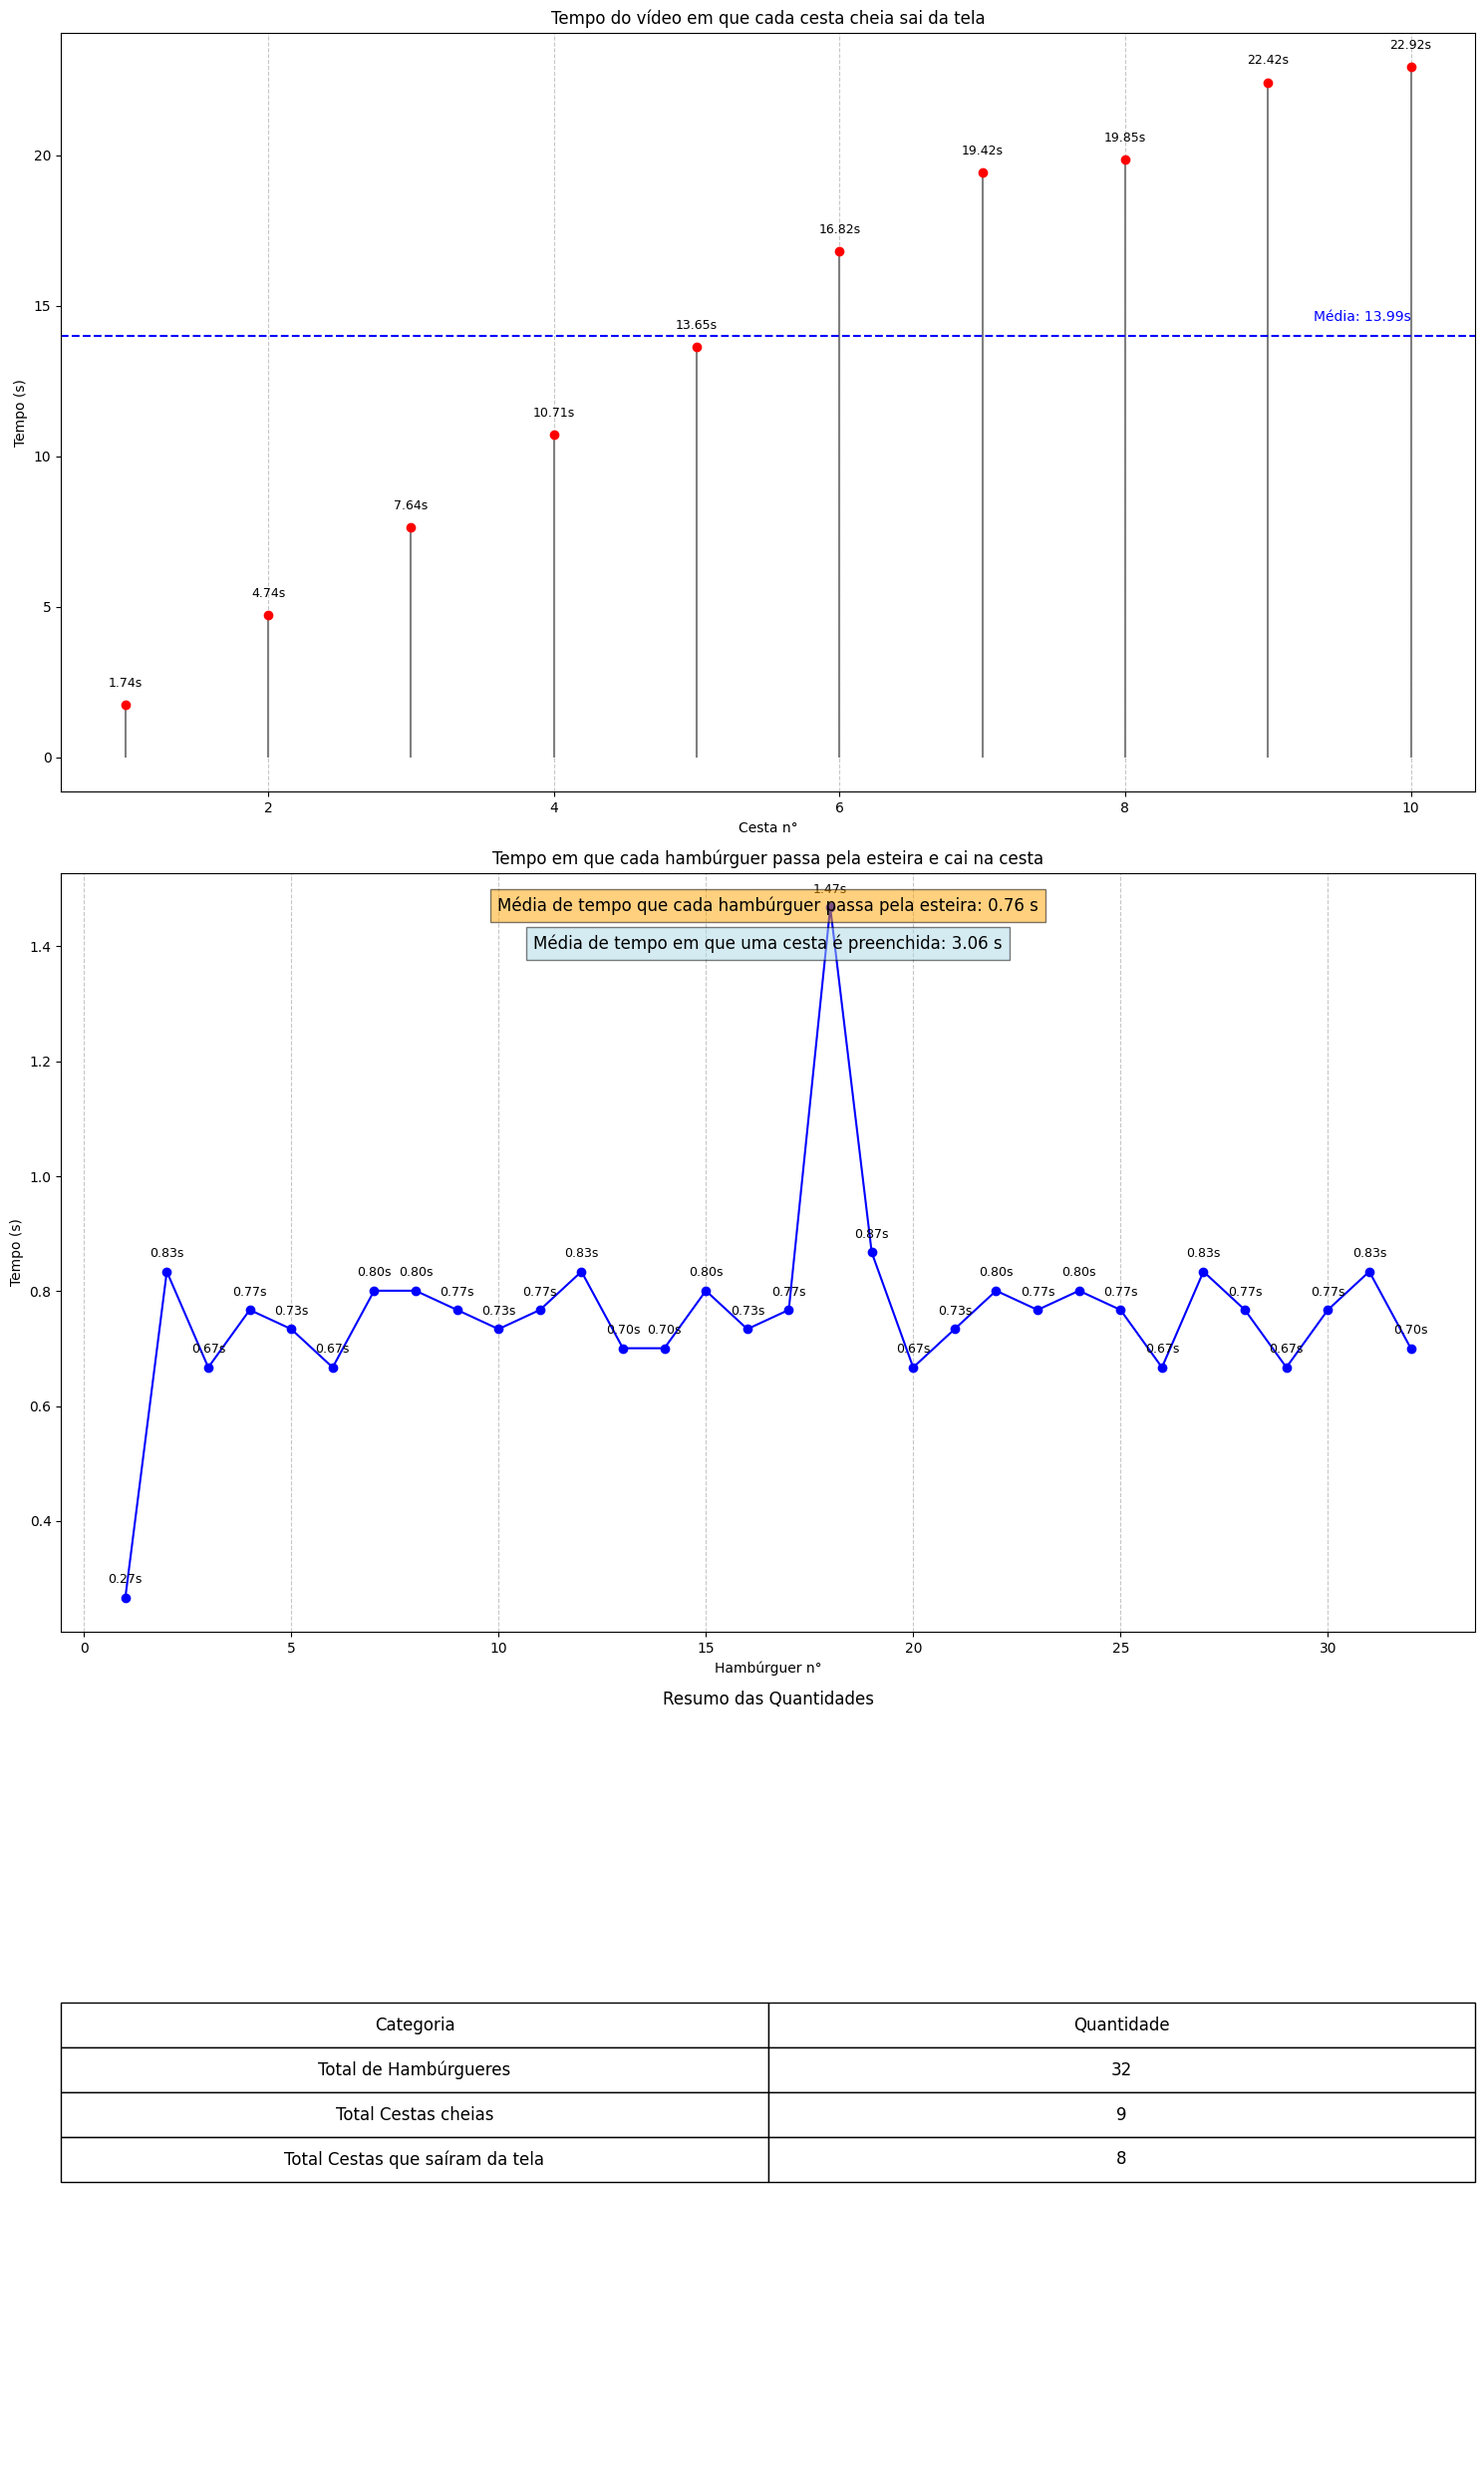


Tempos originais de cruzamento dos hambúrgueres:
{1: 0.26693360026693363, 2: 1.1011011011011012, 3: 1.7684351017684352, 4: 2.5358692025358693, 5: 3.2699366032699366, 6: 3.9372706039372707, 7: 4.738071404738071, 8: 5.538872205538873, 9: 6.306306306306307, 10: 7.0403737070403745, 11: 7.807807807807809, 12: 8.641975308641976, 13: 9.342676009342677, 14: 10.043376710043377, 15: 10.844177510844178, 16: 11.578244911578246, 17: 12.345679012345679, 18: 13.813813813813814, 19: 14.68134801468135, 20: 15.348682015348682, 21: 16.08274941608275, 22: 16.883550216883553, 23: 17.650984317650988, 24: 18.451785118451784, 25: 19.21921921921922, 26: 19.886553219886554, 27: 20.72072072072072, 28: 21.488154821488155, 29: 22.15548882215549, 30: 22.922922922922925, 31: 23.75709042375709, 32: 24.457791124457792}

Tempos ajustados de cruzamento dos hambúrgueres:
{1: 0.26693360026693363, 2: 0.8341675008341676, 3: 0.6673340006673341, 4: 0.7674341007674341, 5: 0.7340674007340673, 6: 0.6673340006673341, 7: 0.800800

In [10]:
# @title Challenge J&F

!pip install ultralytics

from ultralytics import YOLO
from collections import defaultdict
import cv2
import numpy as np
import matplotlib.pyplot as plt

path_model = '/content/best.pt'# @param {type:"string"}


video_source = '/content/burger-trim.mp4'# @param {type:"string"}
model = YOLO(path_model)
class_names = model.names

class_counts = defaultdict(int)
crossed_ids_hamburguer = set()
crossed_ids_four_hamburguer = set()
cross_count_hamburguer = 0
cross_count_four_hamburguer = 0

previous_positions_hamburguer = {}
previous_positions_four_hamburguer = {}

counted_ids_four_hamburguer = set()

hamburguer_cross_times = {}
hamburguer_id_mapping = {}
next_hamburguer_id = 1

no_four_hamburguer_times = []
four_hamburguer_present_prev = False

seen_hamburguer_ids = set()
seen_four_hamburguer_ids = set()


cap = cv2.VideoCapture(video_source)

if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('video_contagens.mp4', fourcc, 30.0,
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

line_x = None
line_y = None
vertical_line_percentage = 0.85
margin = 10

all_hamburguer_cross_times = {}
all_no_four_hamburguer_times = []
for result in model.track(source=video_source, conf=0.5, iou=0.7, device='cuda', tracker='bytetrack.yaml'):
    ret, frame = cap.read()
    if not ret:
        break

    if line_x is None or line_y is None:
        frame_height, frame_width = frame.shape[:2]
        line_x = int(frame_width * vertical_line_percentage)
        line_y = int(frame_height * 0.8)

    current_hamburguer_ids = set()
    current_four_hamburguer_ids = set()

    if hasattr(result.boxes, 'cls') and result.boxes.cls is not None and len(result.boxes) > 0:
        class_indices = result.boxes.cls.cpu().numpy().astype(int)
        if hasattr(result.boxes, 'id') and result.boxes.id is not None:
            ids = result.boxes.id.cpu().numpy().astype(int)
        else:
            ids = [None] * len(class_indices)

        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        detections_per_class = defaultdict(list)

        for idx, cls_idx in enumerate(class_indices):
            cls_name = class_names[cls_idx]
            box = boxes[idx]
            obj_id = ids[idx] if ids[idx] is not None else idx
            score = scores[idx]
            detections_per_class[cls_name].append({'box': box, 'id': obj_id, 'score': score})

        print(f"Classes detectadas no frame: {list(detections_per_class.keys())}")

        for cls_name, detections in detections_per_class.items():
            if cls_name == 'hamburguer':
                for det in detections:
                    obj_id = det['id']
                    current_hamburguer_ids.add(obj_id)
                    if obj_id not in seen_hamburguer_ids:
                        class_counts['hamburguer'] += 1
                        seen_hamburguer_ids.add(obj_id)
                        print(f"'hamburguer' ID {obj_id} detectado pela primeira vez. Contagem: {class_counts['hamburguer']}")

                for det in detections:
                    x1, y1, x2, y2 = map(int, det['box'])
                    obj_id = det['id']
                    center_x = int((x1 + x2) / 2)
                    center_y = int((y1 + y2) / 2)
                    cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)

                    if obj_id in crossed_ids_hamburguer:
                        continue  # Já foi contado

                    previous_x = previous_positions_hamburguer.get(obj_id, None)
                    print(f"Obj ID: {obj_id}, Previous_x: {previous_x}, x2: {x2}, center_x: {center_x}, line_x: {line_x}")

                    if previous_x is not None:
                        if (previous_x < line_x - margin <= center_x + margin) or (previous_x < line_x - margin <= x2 + margin):
                            cross_count_hamburguer += 1
                            crossed_ids_hamburguer.add(obj_id)

                            if obj_id not in hamburguer_id_mapping:
                                hamburguer_id_mapping[obj_id] = next_hamburguer_id
                                next_hamburguer_id += 1
                            new_id = hamburguer_id_mapping[obj_id]

                            current_time_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
                            current_time_sec = current_time_ms / 1000.0
                            hamburguer_cross_times[new_id] = current_time_sec

                            print(f"'hamburguer' Novo ID {new_id} (obj_id {obj_id}) cruzou a linha vertical em {current_time_sec:.2f}s. Cruzamentos: {cross_count_hamburguer}")
                            all_hamburguer_cross_times[new_id] = current_time_sec

                    previous_positions_hamburguer[obj_id] = center_x

                    if previous_x is not None:
                        cv2.circle(frame, (previous_x, center_y), 5, (255, 0, 0), -1)

            elif cls_name == '4-hamburguer':
                for det in detections:
                    obj_id = det['id']
                    current_four_hamburguer_ids.add(obj_id)
                    if obj_id not in seen_four_hamburguer_ids:
                        class_counts['4-hamburguer'] += 1
                        seen_four_hamburguer_ids.add(obj_id)
                        counted_ids_four_hamburguer.add(obj_id)
                        print(f"'4-hamburguer' ID {obj_id} detectado pela primeira vez. Contagem: {class_counts['4-hamburguer']}")

                for det in detections:
                    x1, y1, x2, y2 = map(int, det['box'])
                    obj_id = det['id']
                    center_y = int((y1 + y2) / 2)

                    if obj_id in crossed_ids_four_hamburguer:
                        continue

                    previous_y = previous_positions_four_hamburguer.get(obj_id, None)

                    if previous_y is not None:
                        if previous_y < line_y <= center_y:
                            cross_count_four_hamburguer += 1
                            crossed_ids_four_hamburguer.add(obj_id)
                            print(f"'4-hamburguer' ID {obj_id} cruzou a linha horizontal. Cruzamentos: {cross_count_four_hamburguer}")
                            if class_counts['4-hamburguer'] > cross_count_four_hamburguer:
                                excess = class_counts['4-hamburguer'] - cross_count_four_hamburguer
                                class_counts['4-hamburguer'] -= excess
                                print(f"Ajuste realizado: Decrementou {excess} de class_counts['4-hamburguer'] para alinhar com cross_count_four_hamburguer.")
                            all_no_four_hamburguer_times.append(current_time_sec)

                    previous_positions_four_hamburguer[obj_id] = center_y
                    cv2.circle(frame, (center_x, center_y), 5, (255, 0, 255), -1)
    if '4-hamburguer' in detections_per_class and len(detections_per_class['4-hamburguer']) > 0:
        four_hamburguer_present_prev = True
    else:
        if four_hamburguer_present_prev:
            current_time_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            current_time_sec = current_time_ms / 1000.0
            no_four_hamburguer_times.append(current_time_sec)
            print(f"'4-hamburguer' não detectados no tempo {current_time_sec:.2f}s.")
            four_hamburguer_present_prev = False
    y_offset = 30
    cls_name = '4-hamburguer'
    if cls_name in class_counts:
        count = class_counts[cls_name]
        text = f"Cestas cheias: {count}"
        cv2.putText(frame, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (255, 0, 0), 2)
        y_offset += 30
    cross_text = f"Hamburgueres: {cross_count_hamburguer}"
    cv2.putText(frame, cross_text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    y_offset += 30

    cross_text = f"Cestas fora da dela: {cross_count_four_hamburguer}"
    cv2.putText(frame, cross_text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Total de hamburguer que cruzaram a linha vertical: {cross_count_hamburguer}")
print(f"Total de 4-hamburguer que cruzaram a linha horizontal: {cross_count_four_hamburguer}")

if no_four_hamburguer_times:
    print("\nTempos em que os '4-hamburguer' não foram mais detectados:")
    for time_sec in no_four_hamburguer_times:
        print(f"{time_sec:.2f} segundos")
else:
    print("\nNenhum evento de '4-hamburguer' não detectados foi registrado.")

if no_four_hamburguer_times:
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    ax1 = axs[0]
    ids = range(1, len(no_four_hamburguer_times) + 1)
    times = no_four_hamburguer_times
    markerline, stemlines, baseline = ax1.stem(ids, times, linefmt='grey', markerfmt='o', basefmt=" ")
    plt.setp(markerline, color='red')
    plt.setp(stemlines, color='grey')
    plt.setp(baseline, visible=False)
    for i, time in enumerate(times):
        ax1.text(ids[i], time + 0.5, f'{time:.2f}s', ha='center', va='bottom', fontsize=9)
    ax1.set_xlabel('Cesta n°')
    ax1.set_ylabel('Tempo (s)')
    ax1.set_title('Tempo do vídeo em que cada cesta cheia sai da tela')
    ax1.grid(True, axis='x', linestyle='--', alpha=0.7)
    average_no_four_time = sum(times) / len(times)
    print(f"\nMédia dos tempos de ausência de '4-hamburguer': {average_no_four_time:.2f} s")
    ax1.axhline(y=average_no_four_time, color='blue', linestyle='--', label=f'Média: {average_no_four_time:.2f}s')
    ax1.text(ids[-1], average_no_four_time + 0.5, f'Média: {average_no_four_time:.2f}s', color='blue', fontsize=10, ha='right')
    ax2 = axs[1]
    if hamburguer_cross_times:
        keys = sorted(hamburguer_cross_times.keys())
        adjusted_hamburguer_times = {}
        for i, key in enumerate(keys):
            if i == 0:
                adjusted_time = hamburguer_cross_times[key]
            else:
                adjusted_time = hamburguer_cross_times[key] - hamburguer_cross_times[keys[i - 1]]
            adjusted_hamburguer_times[key] = adjusted_time

        ids_hamburguer = keys
        times_hamburguer = [adjusted_hamburguer_times[key] for key in keys]

        ax2.plot(ids_hamburguer, times_hamburguer, marker='o', linestyle='-', color='blue')
        for i, time in enumerate(times_hamburguer):
            ax2.text(ids_hamburguer[i], time + 0.02, f'{time:.2f}s', ha='center', va='bottom', fontsize=9)

        ax2.set_xlabel('Hambúrguer n°')
        ax2.set_ylabel('Tempo (s)')
        ax2.set_title('Tempo em que cada hambúrguer passa pela esteira e cai na cesta')
        ax2.grid(True, axis='x', linestyle='--', alpha=0.7)

        average_time = sum(times_hamburguer) / len(times_hamburguer)
        print(f"\nMédia dos tempos ajustados: {average_time:.2f} s")

        group_size = 4
        group_sums = []
        num_groups = len(times_hamburguer) // group_size

        for i in range(num_groups):
            group = times_hamburguer[i * group_size:(i + 1) * group_size]
            group_sum = sum(group)
            group_sums.append(group_sum)

        print(f"Somas dos grupos de {group_size} hambúrgueres: {group_sums}")

        if group_sums:
            overall_group_average = sum(group_sums) / len(group_sums)
            print(f"Média de tempo em que uma cesta é preenchida: {overall_group_average:.2f} s")
        else:
            overall_group_average = 0
            print("Não há grupos completos de quatro hambúrgueres para calcular a média.")

        ax2.text(0.5, 0.95, f"Média de tempo que cada hambúrguer passa pela esteira: {average_time:.2f} s",
                 transform=ax2.transAxes, fontsize=12, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5}, ha='center')

        ax2.text(0.5, 0.90, f"Média de tempo em que uma cesta é preenchida: {overall_group_average:.2f} s",
                 transform=ax2.transAxes, fontsize=12, bbox={"facecolor": "lightblue", "alpha": 0.5, "pad": 5}, ha='center')
    else:
        ax2.text(0.5, 0.5, "Nenhum hambúrguer cruzou a linha para gerar este gráfico.",
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax2.axis('off')
    ax3 = axs[2]
    resumo_data = [
        ["Total de Hambúrgueres", cross_count_hamburguer],
        ["Total Cestas cheias", class_counts.get('4-hamburguer', 0)],
        ["Total Cestas que saíram da tela", cross_count_four_hamburguer]
    ]
    table = ax3.table(cellText=resumo_data, colLabels=["Categoria", "Quantidade"], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    ax3.axis('off')
    ax3.set_title('Resumo das Quantidades')

    plt.tight_layout()
    plt.savefig('grafico_completo_resumo.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Nenhum dado disponível para gerar o gráfico.")

if hamburguer_cross_times:
    print("\nTempos originais de cruzamento dos hambúrgueres:")
    print(hamburguer_cross_times)
    adjusted_hamburguer_times = {}
    keys = sorted(hamburguer_cross_times.keys())
    for i, key in enumerate(keys):
        if i == 0:
            adjusted_time = hamburguer_cross_times[key]
        else:
            adjusted_time = hamburguer_cross_times[key] - hamburguer_cross_times[keys[i - 1]]
        adjusted_hamburguer_times[key] = adjusted_time
    print("\nTempos ajustados de cruzamento dos hambúrgueres:")
    print(adjusted_hamburguer_times)

    data = []
    for key in keys:
        data.append([f'Hamburguer {key}', f'{adjusted_hamburguer_times[key]:.4f}'])
    column_labels = ["Hamburguer ID", "Diferença de Tempo (s)"]
else:
    print("Nenhum dado disponível para gerar o gráfico.")

